## Clasificacion de tweets según sentimiento con Bag-of-words,

**CAIRO Lucia** **13030**

El objetivo es construir un modelo de clasificación de sentimientos usando el método Bag-of-Words (BoW) en un dataset de tweets llamado Sentiment140. Este dataset contiene 1.6 millones de tweets que han sido etiquetados como positivos (4) o negativos (0).

#### Descripción del Dataset

El dataset utilizado proviene de Kaggle y contiene tweets etiquetados como positivos (4) o negativos (0).

Dataset disponible en: https://www.kaggle.com/datasets/kazanova/sentiment140?resource=download

#### Objetivo del Análisis

El objetivo es construir un modelo que aprende de los datos etiquetados para predecir si un tweet nuevo expresa un sentimiento positivo o negativo

1. **Importar las bibliotecas necesarias**
2. **Cargar el dataset**
3. **Explorar y limpiar los datos**
4. **Preparar los datos**
5. **Dividir los datos**
6. **Método Bag-of-Words (BoW)**
7. **Definir el modelo**
8. **Entrenar el modelo**
9. **Evaluar el modelo**
10. **Interpretacion**
11. **Concluciones**

### 1. Importar las bibliotecas necesarias

In [18]:
import pandas as pd
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from tensorflow import keras
import string
import re

### 2. Cargar el dataset



In [19]:
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
df = pd.read_csv('./training.1600000.processed.noemoticon.csv', encoding='latin-1', names=columns)

# evitar problemas de memoria
df = df[['target', 'text']].sample(frac=0.02, random_state=1)
df.head(5)

,target,text
514293,0,i miss nikki nu nu already shes always there ...
142282,0,So I had a dream last night. I remember a sig...
403727,0,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,0,it is raining again
610789,0,@MissKeriBaby wish I was in LA right now


### 3. Explorar y limpiar los datos


In [20]:
df.info()
df.describe()

df = df[['target', 'text']] # columnas que nos interesan

df['target'] = df['target'].replace({0: 'negativo', 4: 'positivo'})
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 32000 entries, 514293 to 1041000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  32000 non-null  int64 
 1   text    32000 non-null  object
dtypes: int64(1), object(1)
memory usage: 750.0+ KB


,target,text
514293,negativo,i miss nikki nu nu already shes always there ...
142282,negativo,So I had a dream last night. I remember a sig...
403727,negativo,@girlyghost ohh poor sickly you (((hugs)) ho...
649503,negativo,it is raining again
610789,negativo,@MissKeriBaby wish I was in LA right now


### 4. Preparar los datos

In [22]:
# convertir a minúsculas y eliminar puntuación
def custom_standardization(text):
    lowercase_text = text.lower()
    return re.sub(f'[{re.escape(string.punctuation)}]', '', lowercase_text)

df['text'] = df['text'].apply(custom_standardization)

df.head()


,target,text
514293,negativo,i miss nikki nu nu already shes always there ...
142282,negativo,so i had a dream last night i remember a sign...
403727,negativo,girlyghost ohh poor sickly you hugs hope you...
649503,negativo,it is raining again
610789,negativo,misskeribaby wish i was in la right now


**Visualizaciones previas**

*Distribución de sentimientos*

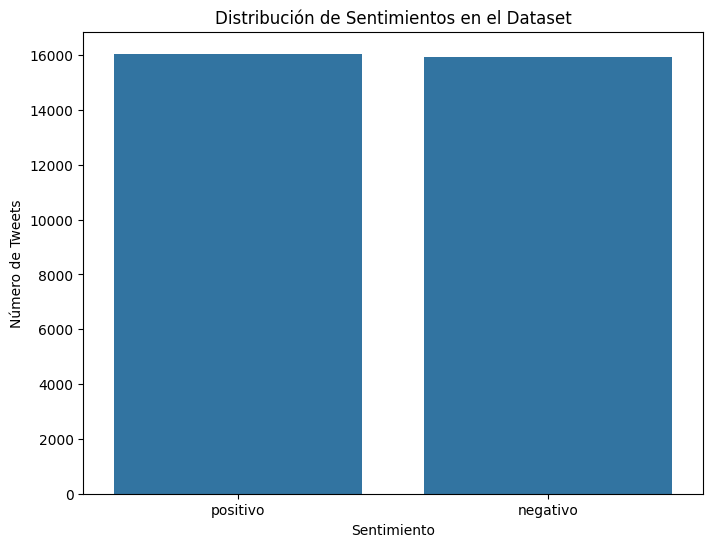

In [23]:
sentiment_counts = df['target'].value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Distribución de Sentimientos en el Dataset')
plt.xlabel('Sentimiento')
plt.ylabel('Número de Tweets')
plt.show()

**Palabras más frecuentes en tweets**

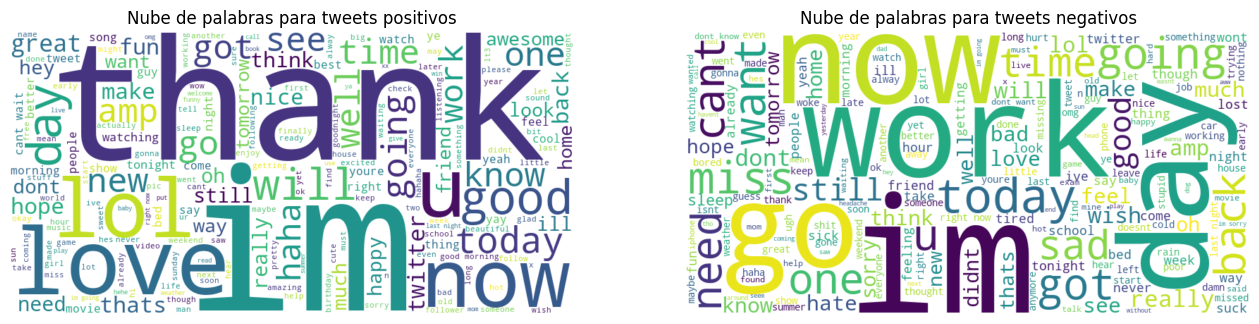

C:\Users\Luci\AppData\Local\Temp\ipykernel_12700\3676807711.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target'] = df['target'].replace({'negativo': 0 , 'positivo':4})


In [24]:
from collections import Counter

positive_tweets = df[df['target'] == 'positivo']['text'].str.cat(sep=' ')
negative_tweets = df[df['target'] == 'negativo']['text'].str.cat(sep=' ')

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_tweets)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_tweets)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Nube de palabras para tweets positivos')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Nube de palabras para tweets negativos')
plt.axis('off')

plt.show()

df['target'] = df['target'].replace({'negativo': 0 , 'positivo':4})
df['target'] = df['target'].replace(4, 1)

### 5. Dividir los datos 

In [25]:
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

# Los modelos de aprendizaje profundo solo pueden procesar tensores 
# necesario vectorizar el texto, transformándolo a tensores
train_texts = train_df['text'].values
train_labels = train_df['target'].values
test_texts = test_df['text'].values
test_labels = test_df['target'].values

### 6. Método Bag-of-Words (BoW)

In [27]:
# ignora el orden de las palabras y trata el texto como un conjunto desordenado de palabras.

# tokenizamos y convierte el texto a representaciones de bag-of-words
max_tokens = 2000 
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode='multi_hot'  # Bag-of-Words
)

# adaptamos el vectorizador al conjunto de entrenamiento
text_vectorization.adapt(train_texts)

# vectorizamos el conjunto de entrenamiento y prueba
train_texts_vectorized = text_vectorization(train_texts)
test_texts_vectorized = text_vectorization(test_texts)


### 7. Definir el modelo

In [29]:

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = keras.layers.Dense(hidden_dim, activation="relu")(inputs)
    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x) 
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

model = get_model(max_tokens=max_tokens)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 2000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │        32,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,033 (125.13 KB)

 Trainable params: 32,033 (125.13 KB)

 Non-trainable params: 0 (0.00 B)

### 8. Entrenar el modelo

In [30]:
batch_size = 32
epochs = 10

model.fit(
    train_texts_vectorized, train_labels,
    validation_data=(test_texts_vectorized, test_labels),
    epochs=epochs,
    batch_size=batch_size
)


Epoch 1/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6242 - loss: 0.6487 - val_accuracy: 0.7314 - val_loss: 0.5502
Epoch 2/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7419 - loss: 0.5396 - val_accuracy: 0.7452 - val_loss: 0.5263
Epoch 3/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7616 - loss: 0.5106 - val_accuracy: 0.7548 - val_loss: 0.5219
Epoch 4/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7722 - loss: 0.5033 - val_accuracy: 0.7566 - val_loss: 0.5245
Epoch 5/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7711 - loss: 0.5002 - val_accuracy: 0.7527 - val_loss: 0.5274
Epoch 6/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7714 - loss: 0.5025 - val_accuracy: 0.7545 - val_loss: 0.5291
Epoch 7/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7762 - loss: 0.4958 - val_accuracy: 0.7525 - val_loss: 0.5299
Epoch 8/10
800/800 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7766 - loss: 0.4965 - val_accuracy: 0.

### 9. Evaluar el modelo

In [31]:
test_loss, test_acc = model.evaluate(test_texts_vectorized, test_labels)
print(f"Loss: {test_loss:.3f}")
print(f"Test accuracy: {test_acc:.3f}")


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7606 - loss: 0.5294
Loss: 0.530
Test accuracy: 0.756


### 10. Interpretacion 

200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


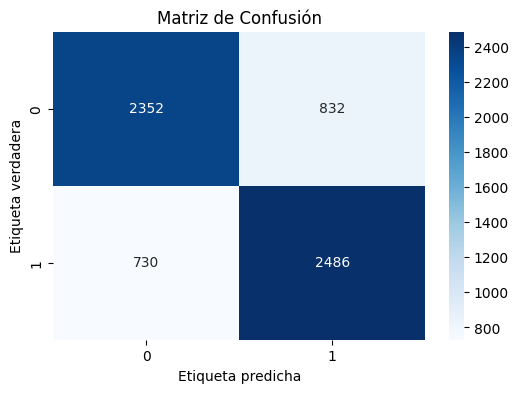

In [32]:
# Matriz de confusión
 
from sklearn.metrics import confusion_matrix
predictions = model.predict(test_texts_vectorized)
y_pred = (predictions > 0.5).astype("int32")
y_test = test_labels

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Etiqueta verdadera')
plt.xlabel('Etiqueta predicha')
plt.title('Matriz de Confusión')
plt.show()

- **2352** tweets **negativos correctamente** clasificados como negativos (verdaderos negativos).
- **832** tweets **negativos incorrectamente** clasificados como positivos (falsos positivos).
- **730** tweets **positivos incorrectamente** clasificados como negativos (falsos negativos).
- **2486** tweets **positivos correctamente** clasificados como positivos (verdaderos positivos).

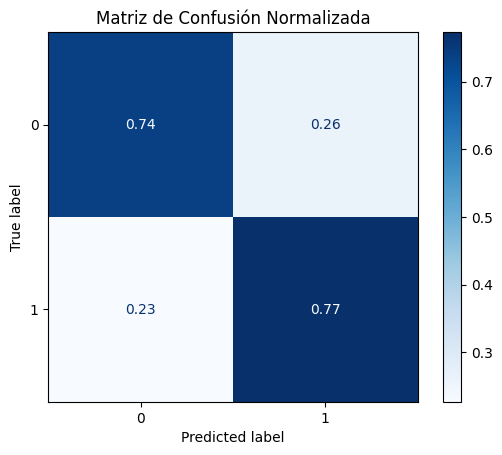

In [40]:
# Matriz de confusión normalizada
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Matriz de confusión normalizada
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

disp_normalized = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=[0, 1])
disp_normalized.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión Normalizada")
plt.show()

In [41]:
# Informe de clasificación
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

           0       0.76      0.74      0.75      3184
           1       0.75      0.77      0.76      3216

    accuracy                           0.76      6400
   macro avg       0.76      0.76      0.76      6400
weighted avg       0.76      0.76      0.76      6400



**Clase 0 (Tweets negativos)**
   - **Precision (Precisión)**: de todos los tweets que el modelo predijo como negativos, el 76% realmente eran negativos.
   - **Recall (Sensibilidad)**: de todos los tweets que realmente eran negativos, el modelo identificó correctamente el 74%.
   - **Support**: en total había 3184 tweets negativos en el conjunto de pruebas.

**Clase 1 (Tweets positivos):**
   - **Precision (Precisión)**: de todos los tweets que el modelo predijo como positivos, el 75% realmente eran positivos
   - **Recall (Sensibilidad)**: de todos los tweets que realmente eran positivos, el modelo identificó correctamente el 77%.
   - **Support**: había 3216 tweets positivos en el conjunto de pruebas.

**Accuracy (Precisión Global)**: El modelo clasifica correctamente el 76% de los casos totales.

*El modelo tiene un rendimiento equilibrado en la clasificación de tweets negativos y positivos, lo que refleja una buena capacidad del modelo. La precisión global del 76% es aceptable, pero hay margen para mejorar si se quiere lograr un rendimiento superior.*


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


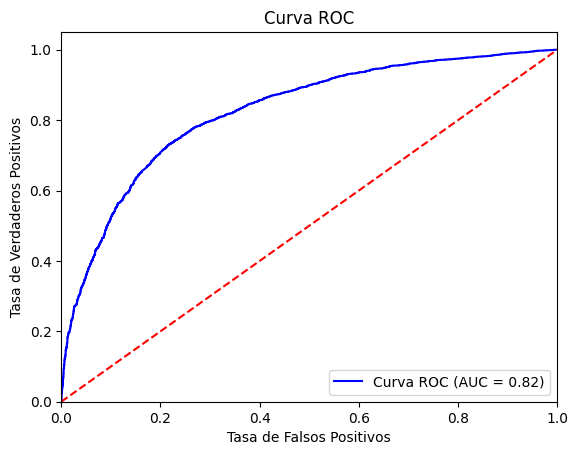

In [43]:
# Curva ROC

from sklearn.metrics import roc_curve, auc

probabilities = model.predict(test_texts_vectorized).flatten()
fpr, tpr, thresholds = roc_curve(test_labels, probabilities)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()


*Elementos*:
- **Eje X (Tasa de Falsos Positivos)**: Representa la **proporción de negativos mal clasificados como positivos** (Falsos Positivos). Un valor de 1 en este eje indica que todos los negativos fueron clasificados incorrectamente como positivos.

- **Eje Y (Tasa de Verdaderos Positivos)**: Representa la **proporción de positivos correctamente clasificados** (Verdaderos Positivos). Un valor de 1 indica que el modelo clasificó correctamente todos los positivos.

- **Curva Azul**: Muestra cómo el rendimiento del modelo cambia a medida que varía el umbral de decisión. Un modelo ideal alcanzaría rápidamente la esquina superior izquierda de la gráfica.

- **Línea Roja Discontinua**: Representa una clasificación completamente aleatoria. Si el modelo estuviera adivinando los resultados, su curva seguiría esta línea (AUC = 0.5).

*Interpretación*:
- **AUC (Area Under the Curve) = 0.82**: Un AUC de 0.82 es considerado **bueno**, ya que indica que el modelo tiene una alta capacidad para distinguir entre clases. 

El modelo tiene un rendimiento bastante sólido. Todavía hay margen de mejora, ya que el modelo no es perfecto (un AUC cercano a 1 sería ideal).

### 11. Concluciones

**Bag-of-Words (BoW)** puede ser una buena opción para el análisis de sentimientos, incluyendo la clasificación de tweets como positivos o negativos por su 
- **simplicidad** 
- **velocidad** 
- **eficacia en textos cortos:** 

Aunque puede tener desventajas como:
- **ignora orden y contexto:** (no captura relaciones semánticas o gramaticales)
- **pérdida de información contextual:** (por ejemplo, "no bueno" vs "bueno")

Para capturar mejor el contexto y las relaciones entre palabras, se consideran métodos más avanzados como **embeddings de palabras** o **Transformers**.

## TWEET POSITIVO O NEGATIVO??

In [46]:

def predict_sentiment(tweet):
    tweet = custom_standardization(tweet)
    tweet_vectorized = text_vectorization(np.array([tweet]))
    prediction = model.predict(tweet_vectorized)
    sentiment = "positivo" if prediction > 0.5 else "negativo"
    return sentiment

# Ejemplo de uso de la función
invented_tweet = "I love this new product, it's amazing!"
#invented_tweet = "I hate everyone, I'm tired of working. I love to complain"
sentiment = predict_sentiment(invented_tweet)
print(f"El tweet: '{invented_tweet}' es {sentiment}.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
El tweet: 'I love this new product, it's amazing!' es positivo.
